# LDA Model Training

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data

In [9]:
data_file_path='DATA.pkl'
data=pd.read_pickle(data_file_path)
data

,seq_no.,seq,module,motif_1,motif_2,motif_3,motif_4,motif_5,motif_string,motif_list
0,0,GGAGGAGGAAGAGGCTGGGCCCCTGCTGTGTGGGGGCAAGTTCCCA...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
1,1,CAAATACCCTGGGGTGCAATACGACTTATATCTCACGTATTGGAAG...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
2,2,AACTAGGACACAGAAGTTGATCTAACGTAAACATCAAGAGCTTCCT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
3,3,CACAGCTGGGCCTGGTTGGTCTTTGTCCAGGGAACAATGGAGCGCC...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
4,4,TTGTTTTATTTGTTTGTTGGGGGGCGGCGGGGAGCGACAGGGGAGT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
...,...,...,...,...,...,...,...,...,...,...
995,995,CTATTATTAAGAAATATACACAATTTTAACTTCAAATATCTCTCAT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
996,996,ATTGATTCTCACTTGCTTGACTCAAGGGAGGGTTTGATTTTGGTCA...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
997,997,ATGTGGTTCTACCATATAGTTTATCAATTTTAAACAGGTAAAATAT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
998,998,ATTTTGTTGGTTAGGTGATGGAAGTATGATGCTATTGATATTTCCC...,2,0.0,1.0,0.0,0.0,1.0,"motif_2,motif_5","[motif_2, motif_5]"


In [10]:
# print(data[data['motif_string'].isna()])
# data.dropna(subset=['motif_string'],inplace=True)
# data['motif_list']=data['motif_string'].apply(lambda x:x.split(','))
# data

In [11]:
from gensim.corpora import Dictionary

docs=data['motif_list'].values
dictionary=Dictionary(docs)

print('Motif-Index to Motif-Name Mapping:')
for i,v in dictionary.items():
    print(f'{i} - {v}')
    if i==10:
        break

Motif-Index to Motif-Name Mapping:
0 - motif_2
1 - motif_3
2 - motif_1
3 - motif_4
4 - motif_5


In [12]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('BOW (Sequence-0):')
docs[0],corpus[0]

BOW (Sequence-0):


(['motif_2', 'motif_3'], [(0, 1), (1, 1)])

## Training Test

In [13]:
%%time
import logging
from gensim.models.callbacks import Callback,PerplexityMetric, ConvergenceMetric, CoherenceMetric

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
convergence_logger = ConvergenceMetric(logger='shell')
from gensim.models import LdaModel,LdaMulticore

temp = dictionary[0]
id2word = dictionary.id2token
lda = LdaModel(corpus, id2word=id2word, alpha='auto',chunksize=10000,
               eta='auto',num_topics=3, iterations=1000, passes = 5,
              minimum_probability=0.0,callbacks=[convergence_logger])

lda_predictions=lda.get_document_topics(corpus,minimum_probability=0.0)
lda_pred_topic=[]
for pred in tqdm(lda_predictions):
    top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
    lda_pred_topic.append(top_topic)
lda_pred_data=data.copy()
lda_pred_data['pred_topic']=lda_pred_topic

logging.getLogger().setLevel(logging.CRITICAL)

2021-03-09 16:49:28,986 : INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
2021-03-09 16:49:28,987 : INFO : using serial LDA version on this node
2021-03-09 16:49:29,007 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 1000x with a convergence threshold of 0.001000
2021-03-09 16:49:29,008 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-03-09 16:49:29,011 : DEBUG : bound: at document #0
2021-03-09 16:49:29,614 : INFO : -2.604 per-word bound, 6.1 perplexity estimate based on a held-out corpus of 1000 documents with 1976 words
2021-03-09 16:49:29,615 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-03-09 16:49:29,616 : DEBUG : performing inference on a chunk of 1000 documents
2021-03-09 16:49:30,231 : DEB

CPU times: user 2.89 s, sys: 43 ms, total: 2.93 s
Wall time: 2.95 s


## Model Evaluation Metrics

In [14]:
lda.get_topic_terms(0)

[(2, 0.6094305),
 (3, 0.38511375),
 (1, 0.0023913234),
 (0, 0.0022632114),
 (4, 0.00080125243)]

In [28]:
def getTopicDistribution(pred_data,ntopics):
    topic_dist_dict={i:0 for i in range(ntopics)}
    value_count=pred_data['pred_topic'].value_counts(normalize=True)
    for k,v in value_count.to_dict().items():
        topic_dist_dict[k]=v
    return topic_dist_dict

def likelihoodMetric(model,pred_data,dictionary,ntopics):
    likelihood=0
    P_T=getTopicDistribution(pred_data,ntopics)
    print(P_T)
    for idx,row in tqdm(pred_data.iterrows()):
        motif_list=dictionary.doc2idx(row['motif_list'])
        assigned_topic_no=row['pred_topic']
        P_Xi_M=0
        for topic_no in range(ntopics):
            ttd=model.get_topic_terms(topic_no)
#             print(ttd)
            filtered_ttd=list(filter(lambda x:x[0] in motif_list,ttd))
            P_X_Ti=1
            for motif,P_mj_T in filtered_ttd:
                P_X_Ti*=P_mj_T
            P_Xi_M+=P_X_Ti*P_T[topic_no]
        likelihood+=np.log10(P_Xi_M)
    print(likelihood)
    return likelihood
likelihoodMetric(lda,lda_pred_data,dictionary,3)

194it [00:00, 1934.72it/s]

{0: 0.478, 1: 0, 2: 0.522}


1000it [00:00, 2402.35it/s]

-1092.4173899022528


-1092.4173899022528

In [16]:
# def getTopicDistribution(predictions,ntopics):
#     topic_count_dict={i:0 for i in range(ntopics)}
#     ndocs=len(predictions)
#     for pred in predictions:
#         top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
#         topic_count_dict[top_topic]+=1
#     topic_dist_dict={k:v/ndocs for k,v in topic_count_dict.items()}
#     print(topic_dist_dict)
#     return topic_dist_dict

# def likelihoodMetric(predictions,ntopics):
#     likelihood=0
#     P_T=getTopicDistribution(predictions,ntopics)
# #     print(P_T)
#     for pred in tqdm(predictions):
#         P_Xi_M=0
#         for topic_no,P_Xi_T in pred:
#             P_Xi_M+=P_Xi_T*P_T[topic_no]
#         likelihood+=np.log10(P_Xi_M)
#     print(likelihood)
#     return likelihood

In [17]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_cv(model,dictionary,docs):
    cm=CoherenceModel(model=model,dictionary=dictionary ,
                      texts=docs, coherence='c_v',processes=30,
                     window_size=2000)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
# coherenceMetric_cv(lda,dictionary ,docs)

In [18]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_umass(model,dictionary,corpus):
    cm = CoherenceModel(model=model, corpus=corpus, \
                        coherence='u_mass',processes=30)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
# coherenceMetric_umass(lda,dictionary ,corpus)

In [19]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_uci(model,dictionary,docs):
    cm=CoherenceModel(model=model,dictionary=dictionary ,
                      texts=docs, coherence='c_uci',processes=30,
                     window_size =2000)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
coherenceMetric_uci(lda,dictionary ,docs)

-12.292968805048053


-12.292968805048053

In [20]:
def perplexityMetric(model,corpus):
    perplexity=model.log_perplexity(corpus)
    print(perplexity)
    return perplexity

In [21]:
from sklearn.metrics.cluster import adjusted_rand_score

def randIndexMetric(predictions,data):
    pred_topic=[]
    for pred in tqdm(predictions):
        topic_prob=sorted(pred,key=lambda x:-x[1])
#         print(topic_prob)
        top_topic=topic_prob[0][0]
        pred_topic.append(top_topic)
    _data=data.copy()
    _data['pred_topic']=pred_topic
    ari=adjusted_rand_score(_data['module'], _data['pred_topic'])
    print(ari)
    return ari

In [22]:
from collections import Counter

def findTopMotifs(pred_data,ntopics,ntop=5,outdir=None):     
    gb=pred_data[['motif_string','pred_topic']].groupby('pred_topic').\
    agg(lambda x: ','.join(x))
    gb['top_motif']=gb['motif_string'].\
    apply(lambda x:Counter(x.split(',')).most_common(ntop))
    gb.reset_index(inplace=True)
    gb=gb[['pred_topic','top_motif']]
    if outdir is not None:
        gb.to_csv(f'{outdir}/top{ntop}_motifs_topics_{ntopics}.csv',index=False)
    print(gb)
    return gb
# findTopMotifs(lda_pred_data,3)

## Training & Evaluation

In [23]:

from gensim.models import LdaModel,LdaMulticore

outdir='model_output'
eval_dict={'num_topics':[],'likelihood':[],'coherence_cv':[],\
          'coherence_umass':[],'coherence_uci':[],'perplexity':[]}
temp = dictionary[0]
id2word = dictionary.id2token
for ntopics in range(2,10):
    print('\n'+'='*40)
    print('Num of Topics = '+str(ntopics))
    model = LdaModel(corpus, id2word=id2word, alpha='auto',chunksize=10000,
                   eta='auto',num_topics=ntopics, iterations=1000, passes = 5,
                  minimum_probability=0.0)
    
    predictions=model.get_document_topics(corpus,minimum_probability=0.0)
    pred_topic=[]
    for pred in tqdm(predictions):
        top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
        pred_topic.append(top_topic)
    pred_data=data.copy()
    pred_data['pred_topic']=pred_topic
    print('\nFinding likelihood...')
#     likelihood=likelihoodMetric(pred_data,predictions,ntopics)
    likelihood=likelihoodMetric(model,pred_data,dictionary,ntopics)
    print('\nFinding coherence_cv...')
    coherence_cv=coherenceMetric_cv(model,dictionary,docs)
    print('\nFinding coherence_umass...')
    coherence_umass=coherenceMetric_umass(model,dictionary ,corpus)
    print('\nFinding coherence_uci...')
    coherence_uci=coherenceMetric_uci(model,dictionary,docs)
    print('\nFinding perplexity...')
    perplexity=perplexityMetric(model,corpus)
    print('\nFinding Top Motifs...')
    findTopMotifs(pred_data,ntopics,outdir=outdir)
#     print('\nFindng avg. distance from TSS per topic...')
#     getAvgTssDist(pred_data,ntopics,outdir=outdir)
    eval_dict['num_topics'].append(ntopics)
    eval_dict['likelihood'].append(likelihood)
    eval_dict['coherence_cv'].append(coherence_cv)
    eval_dict['coherence_umass'].append(coherence_umass)
    eval_dict['coherence_uci'].append(coherence_uci)
    eval_dict['perplexity'].append(perplexity)
eval_df=pd.DataFrame(eval_dict)
eval_df.to_csv(f'{outdir}/metrics.csv',index=False)
eval_df


Num of Topics = 2


100%|██████████| 1000/1000 [00:00<00:00, 5116.47it/s]
267it [00:00, 2668.13it/s]


Finding likelihood...
{0: 0.481, 1: 0.519}


1000it [00:00, 2647.68it/s]

-1115.2293026321174

Finding coherence_cv...


0.22450482415521444

Finding coherence_umass...
-13.792294337173225

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.4222376219143993

Finding Top Motifs...
   pred_topic                                          top_motif
0           0     [(motif_1, 478), (motif_4, 343), (motif_5, 3)]
1           1  [(motif_2, 519), (motif_3, 480), (motif_1, 114...

Num of Topics = 3


100%|██████████| 1000/1000 [00:00<00:00, 3427.22it/s]
230it [00:00, 2290.39it/s]


Finding likelihood...
{0: 0.522, 1: 0.135, 2: 0.343}


1000it [00:00, 2513.55it/s]

-1187.0911612814077

Finding coherence_cv...


0.22450482415521444

Finding coherence_umass...
-13.894599967488512

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.532063183031584

Finding Top Motifs...
   pred_topic                                          top_motif
0           0  [(motif_2, 519), (motif_3, 480), (motif_1, 114...
1           1                                   [(motif_1, 135)]
2           2                   [(motif_1, 343), (motif_4, 343)]

Num of Topics = 4


100%|██████████| 1000/1000 [00:00<00:00, 3798.32it/s]
428it [00:00, 1978.74it/s]


Finding likelihood...
{0: 0.478, 1: 0.48, 2: 0, 3: 0.042}


1000it [00:00, 1934.37it/s]


-1186.3800143385113

Finding coherence_cv...
0.2245048241552145

Finding coherence_umass...
-13.813003008973224

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.5200592862641975

Finding Top Motifs...
   pred_topic                                         top_motif
0           0                  [(motif_1, 478), (motif_4, 343)]
1           1  [(motif_2, 480), (motif_3, 480), (motif_1, 114)]
2           3                    [(motif_5, 42), (motif_2, 39)]

Num of Topics = 5


100%|██████████| 1000/1000 [00:00<00:00, 4442.81it/s]
524it [00:00, 2562.32it/s]


Finding likelihood...
{0: 0.112, 1: 0.042, 2: 0.001, 3: 0.367, 4: 0.478}


1000it [00:00, 2298.78it/s]

-1107.6002348155819

Finding coherence_cv...


0.22450482415521447

Finding coherence_umass...
-13.776889051478008

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.6768657571451384

Finding Top Motifs...
   pred_topic                                         top_motif
0           0  [(motif_1, 112), (motif_2, 112), (motif_3, 112)]
1           1                    [(motif_5, 42), (motif_2, 39)]
2           2                      [(motif_2, 1), (motif_3, 1)]
3           3    [(motif_2, 367), (motif_3, 367), (motif_1, 2)]
4           4                  [(motif_1, 478), (motif_4, 343)]

Num of Topics = 6


100%|██████████| 1000/1000 [00:00<00:00, 2686.23it/s]
300it [00:00, 1489.91it/s]


Finding likelihood...
{0: 0.343, 1: 0, 2: 0.042, 3: 0.434, 4: 0.135, 5: 0.046}


1000it [00:00, 1526.62it/s]

-1173.969833803714

Finding coherence_cv...


0.22450482415521447

Finding coherence_umass...
-13.81250466842699

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.8287697968672705

Finding Top Motifs...
   pred_topic                                         top_motif
0           0                  [(motif_1, 343), (motif_4, 343)]
1           2                    [(motif_5, 42), (motif_2, 39)]
2           3  [(motif_2, 434), (motif_3, 434), (motif_1, 107)]
3           4                                  [(motif_1, 135)]
4           5      [(motif_2, 46), (motif_3, 46), (motif_1, 7)]

Num of Topics = 7


100%|██████████| 1000/1000 [00:00<00:00, 2993.86it/s]
382it [00:00, 1908.88it/s]


Finding likelihood...
{0: 0.186, 1: 0.042, 2: 0.23, 3: 0.342, 4: 0.001, 5: 0.064, 6: 0.135}


1000it [00:00, 1630.77it/s]

-1135.7891378358813

Finding coherence_cv...


0.22450482415521447

Finding coherence_umass...
-13.72232954018428

Finding coherence_uci...
-12.292968805048051

Finding perplexity...
-1.9121518351273377

Finding Top Motifs...
   pred_topic                                        top_motif
0           0  [(motif_2, 186), (motif_3, 186), (motif_1, 10)]
1           1                   [(motif_5, 42), (motif_2, 39)]
2           2  [(motif_2, 230), (motif_3, 230), (motif_1, 40)]
3           3                 [(motif_1, 342), (motif_4, 342)]
4           4                     [(motif_1, 1), (motif_4, 1)]
5           5    [(motif_1, 64), (motif_2, 64), (motif_3, 64)]
6           6                                 [(motif_1, 135)]

Num of Topics = 8


100%|██████████| 1000/1000 [00:00<00:00, 4864.41it/s]
400it [00:00, 1829.84it/s]


Finding likelihood...
{0: 0, 1: 0.478, 2: 0.366, 3: 0, 4: 0, 5: 0.114, 6: 0, 7: 0.042}


1000it [00:00, 1832.16it/s]

-1095.2703647158364

Finding coherence_cv...


0.22450482415521444

Finding coherence_umass...
-13.865865181765843

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-1.8431932463080656

Finding Top Motifs...
   pred_topic                                         top_motif
0           1                  [(motif_1, 478), (motif_4, 343)]
1           2                  [(motif_2, 366), (motif_3, 366)]
2           5  [(motif_1, 114), (motif_2, 114), (motif_3, 114)]
3           7                    [(motif_5, 42), (motif_2, 39)]

Num of Topics = 9


100%|██████████| 1000/1000 [00:00<00:00, 4552.96it/s]
390it [00:00, 1894.40it/s]


Finding likelihood...
{0: 0.044, 1: 0.049, 2: 0, 3: 0.387, 4: 0.135, 5: 0.042, 6: 0.11, 7: 0.233, 8: 0}


1000it [00:00, 1753.25it/s]

-1143.98340634628

Finding coherence_cv...


0.22450482415521444

Finding coherence_umass...
-13.851133946774283

Finding coherence_uci...
-12.292968805048053

Finding perplexity...
-2.007941265518849

Finding Top Motifs...
   pred_topic                                        top_motif
0           0    [(motif_1, 44), (motif_2, 44), (motif_3, 44)]
1           1    [(motif_1, 49), (motif_2, 49), (motif_3, 49)]
2           3  [(motif_2, 387), (motif_3, 387), (motif_1, 21)]
3           4                                 [(motif_1, 135)]
4           5                   [(motif_5, 42), (motif_2, 39)]
5           6                 [(motif_1, 110), (motif_4, 110)]
6           7                 [(motif_1, 233), (motif_4, 233)]


,num_topics,likelihood,coherence_cv,coherence_umass,coherence_uci,perplexity
0,2,-1115.229303,0.224505,-13.792294,-12.292969,-1.422238
1,3,-1187.091161,0.224505,-13.894600,-12.292969,-1.532063
2,4,-1186.380014,0.224505,-13.813003,-12.292969,-1.520059
3,5,-1107.600235,0.224505,-13.776889,-12.292969,-1.676866
4,6,-1173.969834,0.224505,-13.812505,-12.292969,-1.828770
5,7,-1135.789138,0.224505,-13.722330,-12.292969,-1.912152
6,8,-1095.270365,0.224505,-13.865865,-12.292969,-1.843193
7,9,-1143.983406,0.224505,-13.851134,-12.292969,-2.007941


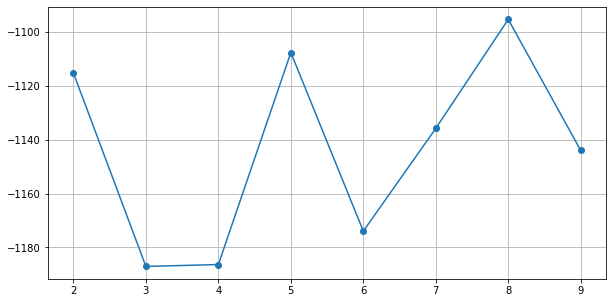

In [24]:
plt.figure(figsize=(10,5))
plt.plot(eval_df['num_topics'],eval_df['likelihood'],marker='o')
plt.grid()

In [25]:
# #setup logging for trainging metrics 
# import logging
# logging.basicConfig(filename='test_output/model_callbacks.log', filemode='w',
#                     format="%(asctime)s:%(levelname)s:%(message)s",
#                     level=logging.NOTSET)

# from gensim.models.callbacks import Callback,PerplexityMetric, ConvergenceMetric, CoherenceMetric
# perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
# convergence_logger = ConvergenceMetric(logger='shell')
# # coherence_cv_logger = CoherenceMetric(corpus=corpus, coherence = 'c_v', texts = docs)

# %%time
# from gensim.models import LdaModel,LdaMulticore

# #HYPERPARAMETERS
# #passes = epochs
# temp = dictionary[0]
# id2word = dictionary.id2token
# lda = LdaModel(corpus, id2word=id2word, alpha='auto',eval_every = 1,\
#                eta='auto',num_topics=3, iterations=5, passes = 10,
#               callbacks=[perplexity_logger,convergence_logger])

# lda.print_topics()

# %%time
# from gensim.models import LdaModel,LdaMulticore

# id2word = dictionary.id2token
# lda = LdaMulticore(corpus, id2word=id2word,eval_every = 1,\
#                eta='auto',num_topics=3, iterations=500, passes = 100)

# import pyLDAvis.gensim

# pyLDAvis.enable_notebook()
# pyLDAvis.gensim.prepare(lda, corpus, dictionary)